## Preprocessing 

On dispose: 
- d'un fichier de prénoms avec la fréquence du sexe des personnes le portant : firstname_with_sex.csv
- d'un fichier contenant les transcriptions manuelle, transcription automatique et le sexe associé : transcriptions_with_sex.csv

L'objectif
est de créer différentes bases de données pour comparer les performances des algorithmes sur les données:
- avec ou sans information statistiques
- avec ou sans preprocessing
- annoté ou prédit

### Import

In [46]:
##############
#  Packages  #
##############
import re
import os
import sys
import nltk
import string
import pickle
import unicodedata
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from typing import Dict, List, Tuple, Any, Optional

###########
#  paths  #
###########
root_path = Path(os.getcwd()).parents[0]
print(root_path)

###################
#      Imports    #
###################

sys.path.insert(0, str(root_path))
from src.visualization.figures import (
    my_wordcloud, 
    var_hist,
    var_box,
    length_hist,
    )

################
#  data paths  #
################

data_path = root_path.joinpath("data")
first_name_path = str(data_path.joinpath("firstname_with_sex.csv"))
transcript_path = str(data_path.joinpath("transcriptions_with_sex.csv"))

C:\Users\samud\Bureau\Python code\MVA\NLP\repo\intro_NLP_projet


### Data loading

In [3]:
###########
#  utils  #
###########

def load(path: Path, sep=";"):
    df = pd.read_csv(path, header=0, sep=sep)
    df = df.drop_duplicates()
    return df

def load_data(first_name_path, transcript_path):
    first_name_df = load(first_name_path, sep = ";")
    transcript_df = load(transcript_path, sep = ",")
    return first_name_df,transcript_df

###########
#  script  #
###########

first_name_df,transcript_df = load_data(first_name_path, transcript_path)
print(f"__Fistname__ shape = {first_name_df.shape}\n,",first_name_df.head())
print(f"\n__Transcript__ shape = {transcript_df.shape}\n",transcript_df.head())

__Fistname__ shape = (6946, 3)
,   firstname     male   female
0     marie    10145  2390322
1      jean  1869615     6476
2    pierre  1475841     5047
3    jeanne     1765  1097397
4  françois  1089009     5951

__Transcript__ shape = (241, 4)
                            subject_line  \
0  ebb26ada-044c-4c62-9dbc-a9c8d505d31c   
1  338496f5-e4ca-43ac-aa5c-429cb3f6ac00   
2  e6a279da-9b6f-4f49-b498-64857bc50d1e   
3  7534deca-39e8-4f00-be17-c12460015de1   
4  ef334a66-a504-418a-9872-e7c9db923488   

                                         groundtruth  \
0  surname: Chardon firstname: Marie occupation: ...   
1  surname: Lhopital firstname: Louis-Jean occupa...   
2  surname: Papin firstname: Marie occupation: id...   
3  surname: Lavocat firstname: Marie link: femme ...   
4      surname: Benne firstname: Marguerite age: 78    

                                          prediction    sex  
0  nom: Chardon prénom: Marie date_naissance: 30 ...  femme  
1  nom: Lhopital prénom: Louis Je

In [4]:
transcript_df["groundtruth"][0]

'surname: Chardon firstname: Marie occupation: idem link: fille age: 30 '

### Transcript expanding

Une première étape est de mettre sous format tabulaire les transcriptions en ajoutant les préfixes gr et pr pour identifier les colonnes d'origines

In [6]:
###########
#  utils  #
###########

def split_string_col(
    joined_col: str, 
    not_col = ["", "...", "... "],
    nan_val = ["...", "n", "", "*", "na", "n", "''", '"', np.nan]
) -> dict:
    
    lst_lst = [val_nextkey.split(" ") for val_nextkey in joined_col.replace("  ", " ").split(": ")]
    dct = {}
    for i in range(1,len(lst_lst)):
        key = lst_lst[i-1][-1]
        value = "-".join(lst_lst[i][:-1])
        if key not in not_col:
            if value in nan_val:
                dct[key] = "nan"
            else:
                dct[key] = value
    return dct

def expand_transcript(df: pd.DataFrame) -> pd.DataFrame:
    df2 = pd.DataFrame({})
    df2["sex"] = df["sex"]
    for col in ["groundtruth", "prediction"]:
        prefix = col[:2]
        for i, row in df.iterrows():
            joined_col = row[col]
            dct_data = split_string_col(joined_col)
            for key, value in dct_data.items():
                df2.loc[i, f"{prefix}_{key}"] = value
    return df2


############
#  script  #
############

expanded_df = expand_transcript(transcript_df)
expanded_df.head()

sex gr_surname gr_firstname gr_occupation gr_link gr_age gr_employer  \
0  femme    Chardon        Marie          idem   fille     30         nan   
1  homme   Lhopital   Louis-Jean            sp    chef     67         nan   
2  femme      Papin        Marie          idem    idem     15        idem   
3  femme    Lavocat        Marie           nan   femme     na         nan   
4  femme      Benne   Marguerite           nan     nan     78         nan   

  gr_birth_date gr_lob gr_civil_status gr_observation    pr_nom   pr_prénom  \
0           nan    nan             nan              n   Chardon       Marie   
1           nan    nan             nan              n  Lhopital  Louis-Jean   
2           nan    nan             nan              n     Pyrin       Marie   
3          1875  Rigny             nan              n   Lavocat       Marie   
4           nan    nan             nan              n     Benne  Marguerite   

  pr_date_naissance pr_lieux_naissance pr_employeur pr_relation pr_profession  \
0                30                nan          nan           n           nan   
1                67                 Sn         ahef           n           nan   
2                55                nan          nan           d           nan   
3              1875              Rigny          nan           n           nan   
4                78                 id          nan         nan           nan   

  pr_état_civil pr_éducation  
0             n            n  
1             n            n  
2             n            n  
3             n            n  
4             n            n

### Typing, char and Nan

Ensuite on harmonise les valeurs manquantes et les types. On ne réalise pas tout de suite un travail complèt sur les caractères.

In [20]:
###########
#  utils  #
###########

def df_nan_harmonization(
    df: pd.DataFrame, lst_value: List[str] = ["*", "", " ", "nan", "n", "NAN"], lst_match: List[str] = [r"NAN"]
) -> pd.DataFrame:
    """
    Harmonise les valeurs NaN dans un DataFrame en remplaçant les valeurs spécifiées.

    Args:
        df (pd.DataFrame): DataFrame à harmoniser.
        lst_value (List[str], optional): Liste des valeurs à remplacer par NaN.
        lst_match (List[str], optional): Liste des motifs de correspondance
            pour les valeurs à remplacer par NaN.

    Returns:
        pd.DataFrame: DataFrame harmonisé avec les valeurs NaN.

    """
    for val in lst_value:
        df = df.replace(val, np.nan)

    for pattern in lst_match:

        def aux_replace(value):
            if isinstance(value, str):
                if re.match(pattern, value, flags=0):
                    return np.nan
            return value

        df = df.map(aux_replace)
    return df

############
#  script  #
############
#typing
first_name_df["male"] = first_name_df["male"].astype("int")
first_name_df["female"] = first_name_df["female"].astype("int")
expanded_df = expanded_df.astype("str")

#
for col in expanded_df:
    if col in ['gr_age', 'gr_birth_date', 'pr_date_naissance']:
        expanded_df[col] = expanded_df[col].str.extract(r'([0-9]+)')
    else:
        expanded_df[col] = expanded_df[col].str.replace(r"([?ï»¿.',]+)", "")

# #nan
first_name_df = df_nan_harmonization(first_name_df)
expanded_df = df_nan_harmonization(expanded_df)

expanded_df.head()

sex gr_surname gr_firstname gr_occupation gr_link gr_age gr_employer  \
0  femme    Chardon        Marie          idem   fille     30         NaN   
1  homme   Lhopital   Louis-Jean            sp    chef     67         NaN   
2  femme      Papin        Marie          idem    idem     15        idem   
3  femme    Lavocat        Marie           NaN   femme    NaN         NaN   
4  femme      Benne   Marguerite           NaN     NaN     78         NaN   

  gr_birth_date gr_lob gr_civil_status gr_observation    pr_nom   pr_prénom  \
0           NaN    NaN             NaN            NaN   Chardon       Marie   
1           NaN    NaN             NaN            NaN  Lhopital  Louis-Jean   
2           NaN    NaN             NaN            NaN     Pyrin       Marie   
3          1875  Rigny             NaN            NaN   Lavocat       Marie   
4           NaN    NaN             NaN            NaN     Benne  Marguerite   

  pr_date_naissance pr_lieux_naissance pr_employeur pr_relation pr_profession  \
0                30                NaN          NaN         NaN           NaN   
1                67                 Sn         ahef         NaN           NaN   
2                55                NaN          NaN           d           NaN   
3              1875              Rigny          NaN         NaN           NaN   
4                78                 id          NaN         NaN           NaN   

  pr_état_civil pr_éducation  
0           NaN          NaN  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN

### Valeurs manquantes

On regarde les proportions de vides:

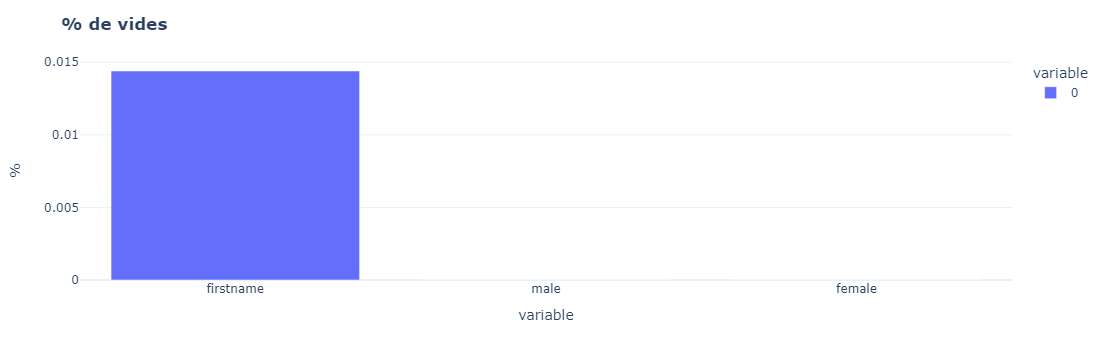

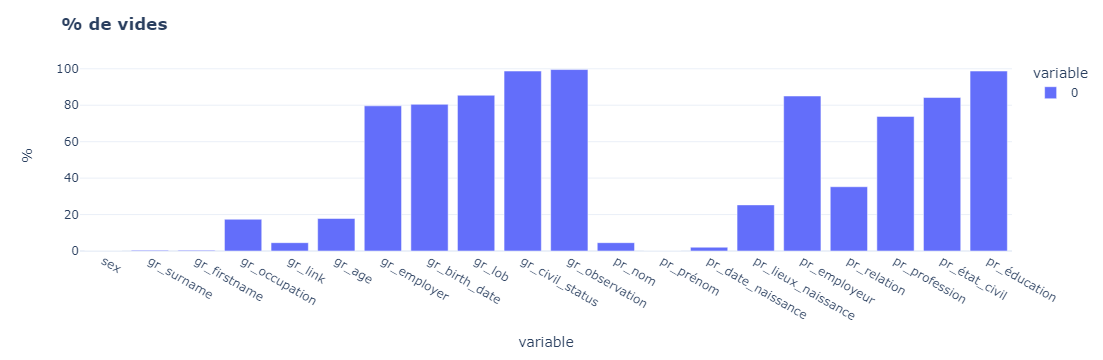

In [21]:
###########
#  utils  #
###########

def nan_bars(df: pd.DataFrame) -> go.Figure:
    """
    Crée un graphique en barres pour afficher le pourcentage de valeurs
    manquantes pour chaque variable dans un DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame pour lequel on veut visualiser
            le pourcentage de non-réponses.

    Returns:
        go.Figure: Le graphique en barres Plotly
            montrant le pourcentage de non-réponses pour chaque variable.
    """
    part_nan = df.isnull().mean()
    perc_nan = pd.DataFrame(100 * part_nan.to_numpy())
    perc_nan.index = part_nan.index
    fig = px.bar(perc_nan, template="plotly_white")
    fig.update_layout(
        title="<b> % de vides </b>",
        xaxis_title="variable",
        yaxis_title="%",
    )
    return fig

############
#  script  #
############

nan_bars(first_name_df).show()
nan_bars(expanded_df).show()

### Statistiques descriptives

On regarde maintenant un peu plus en détail les données:

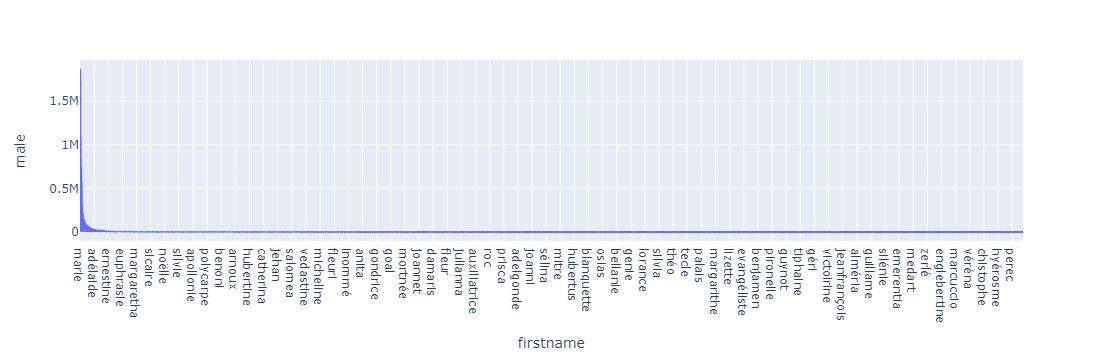

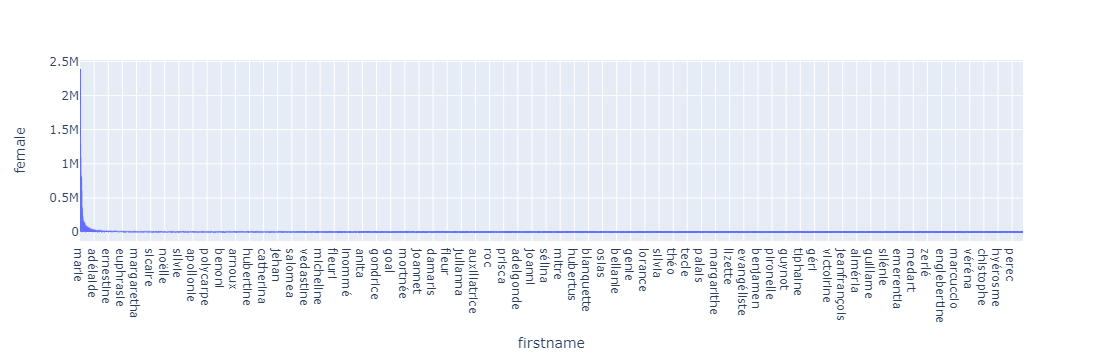

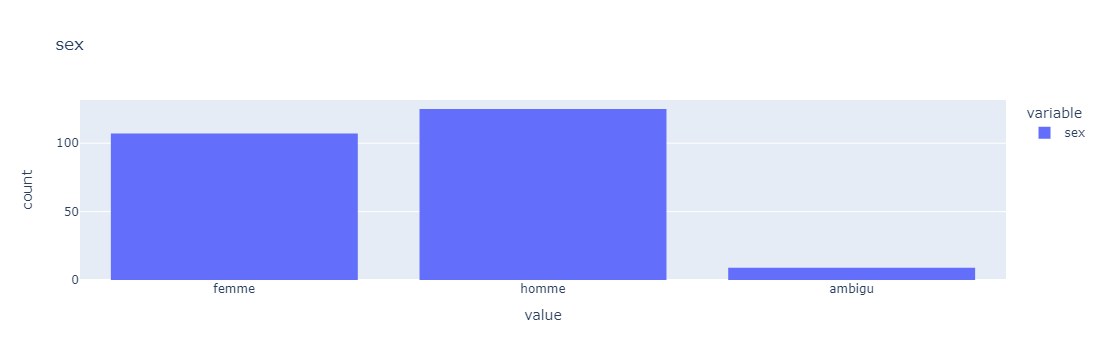

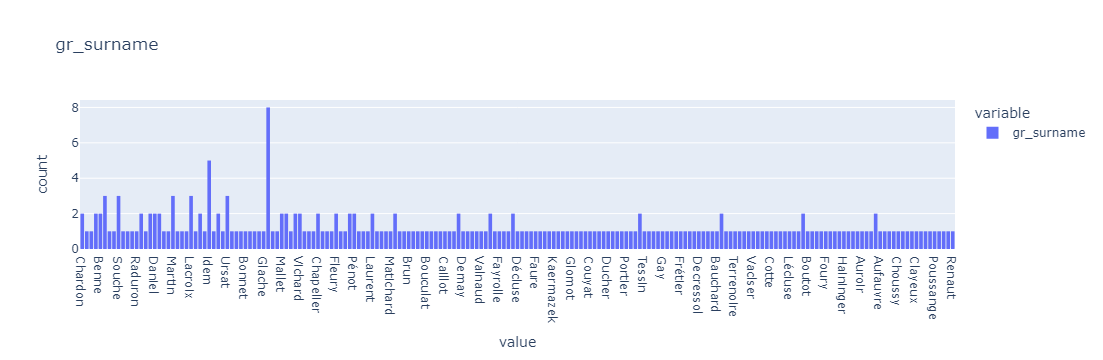

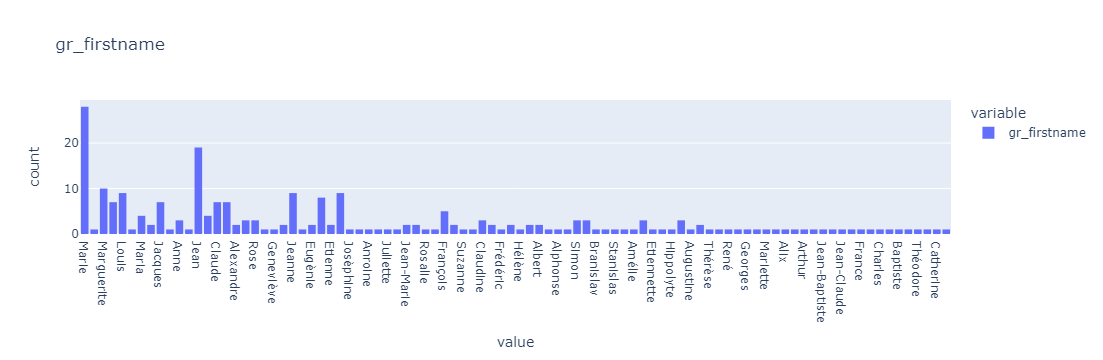

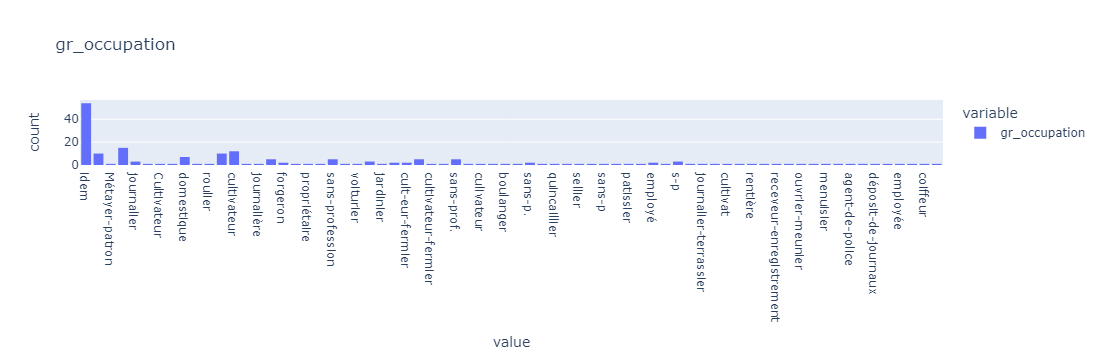

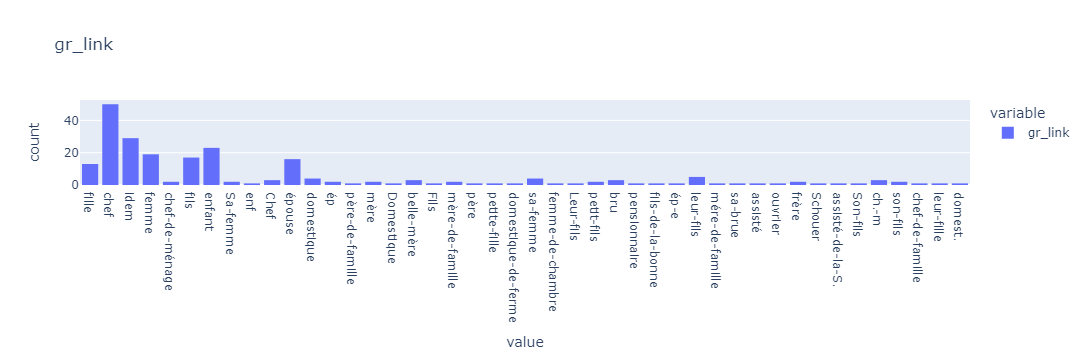

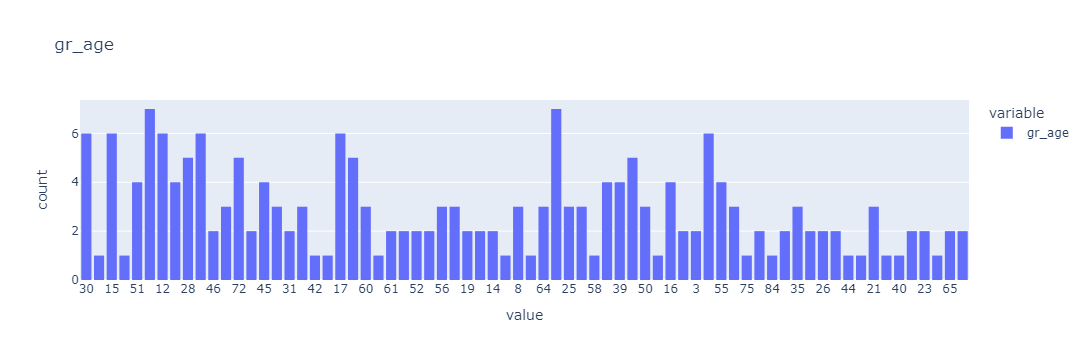

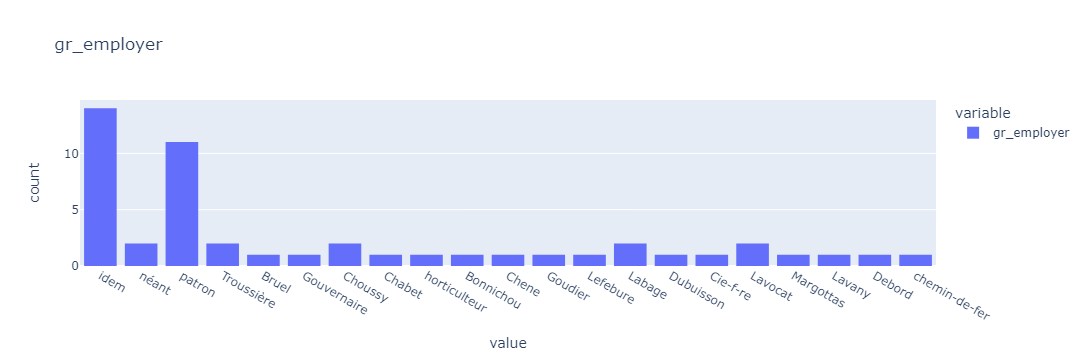

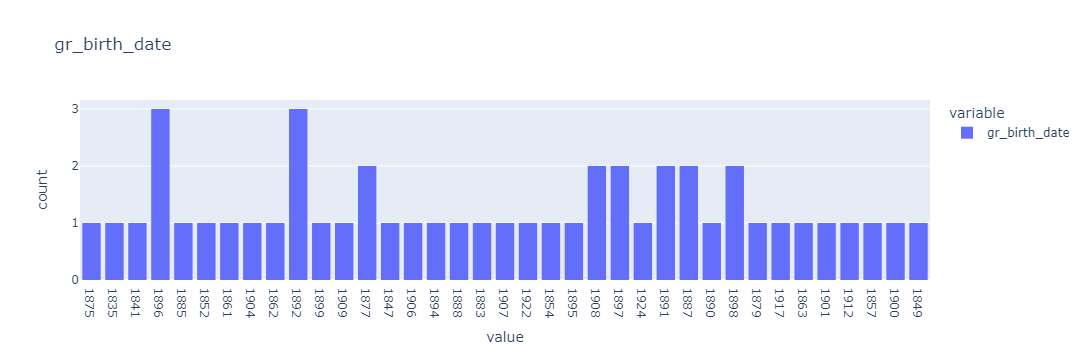

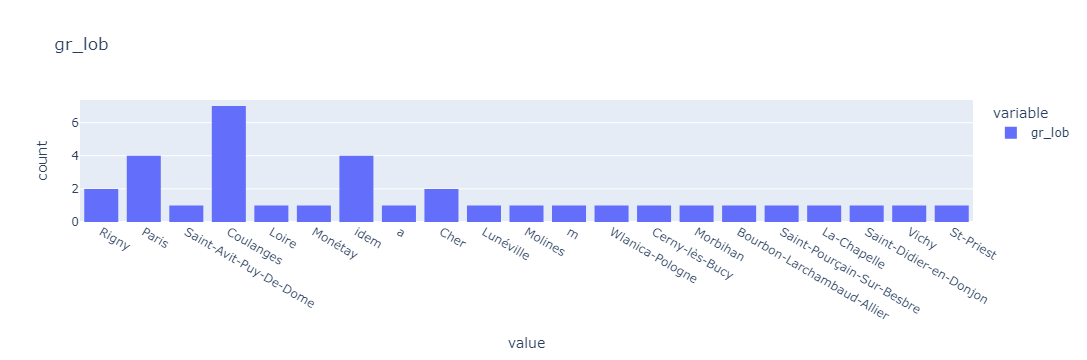

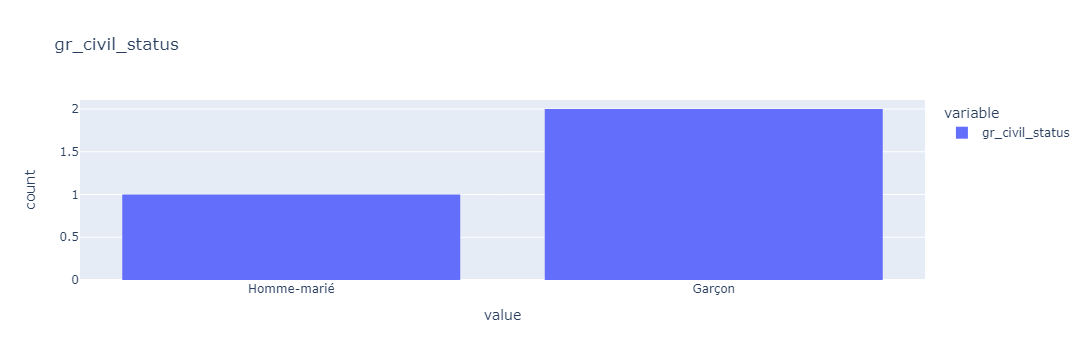

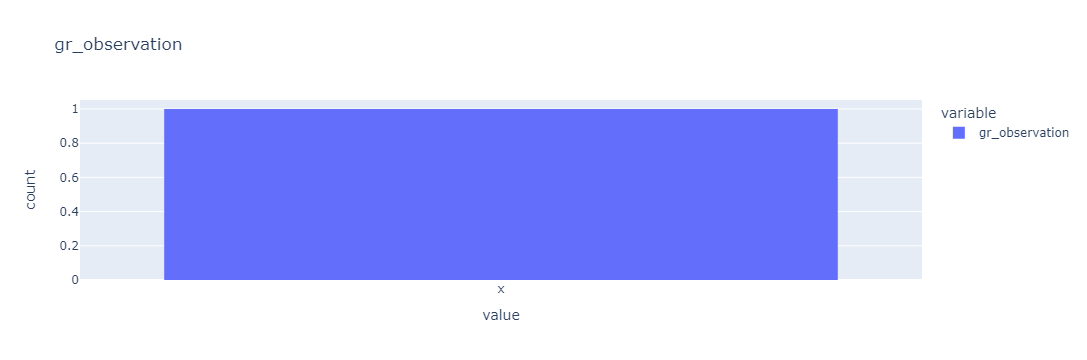

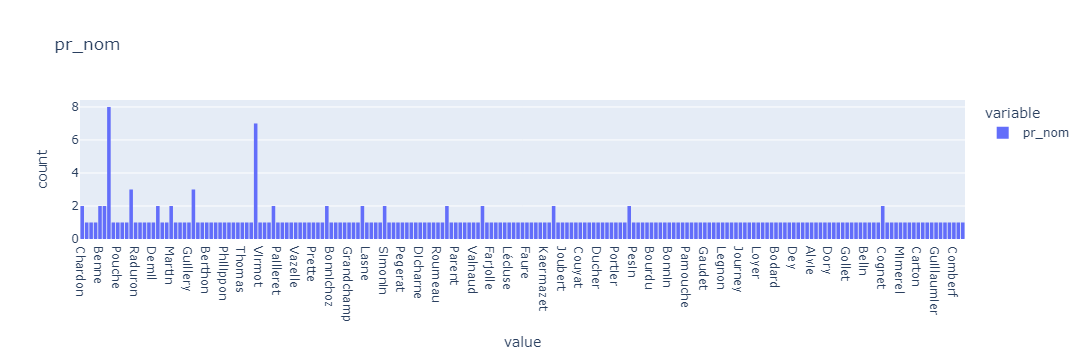

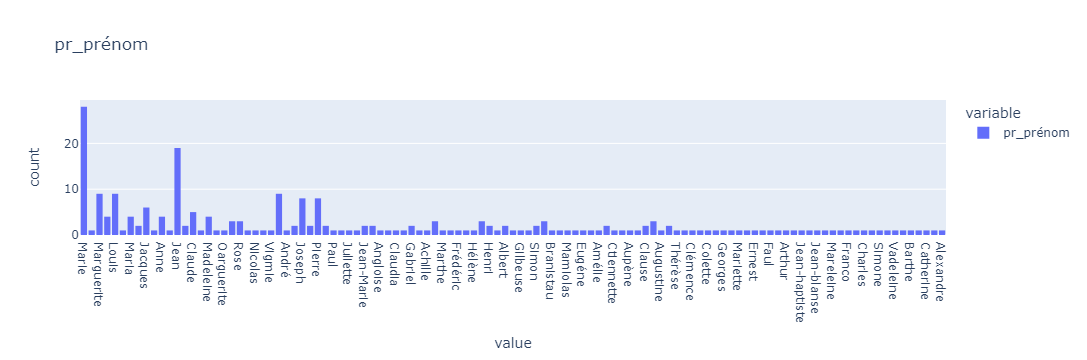

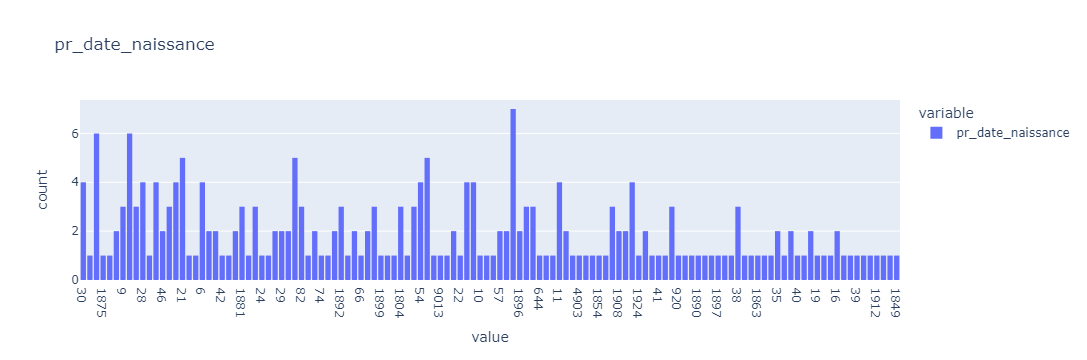

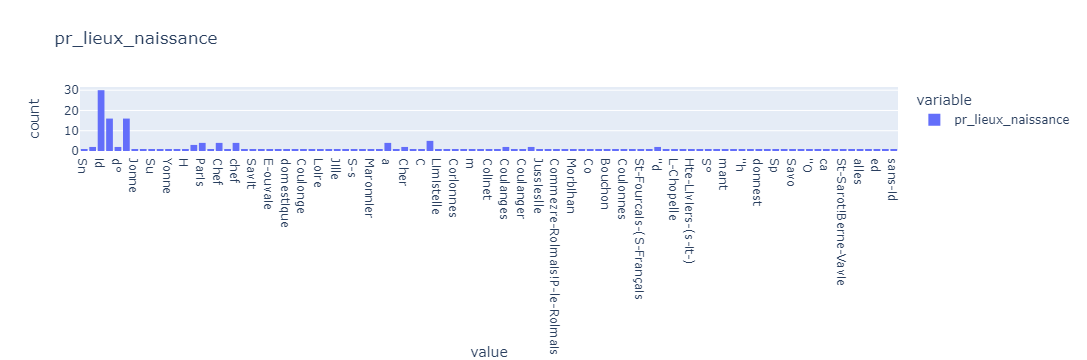

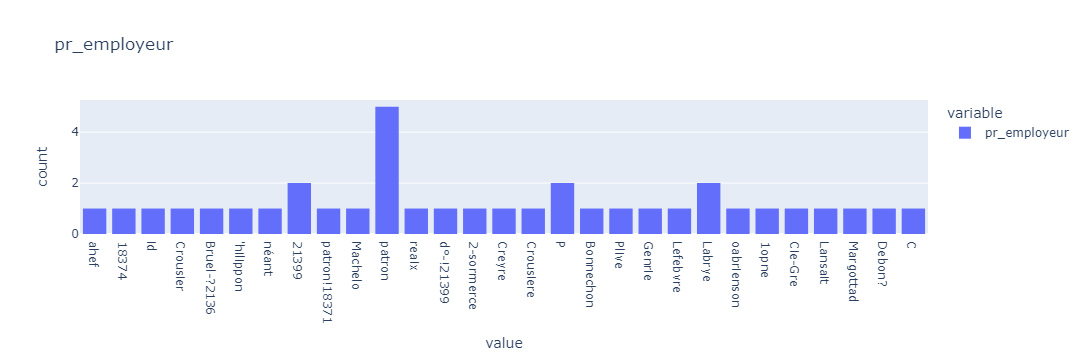

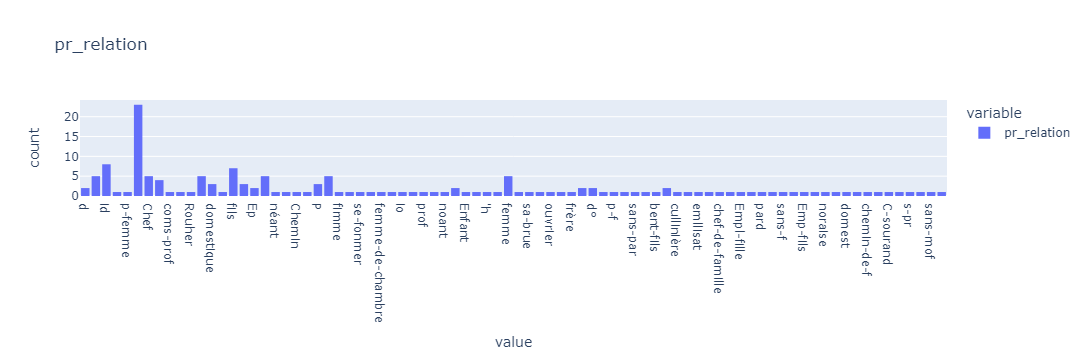

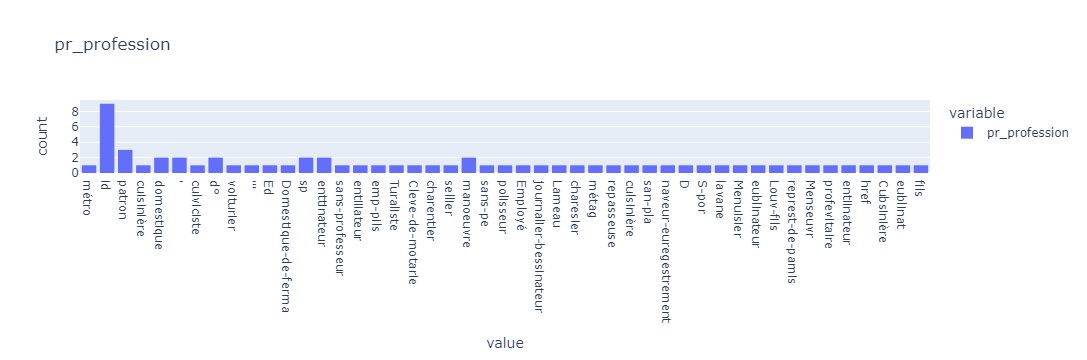

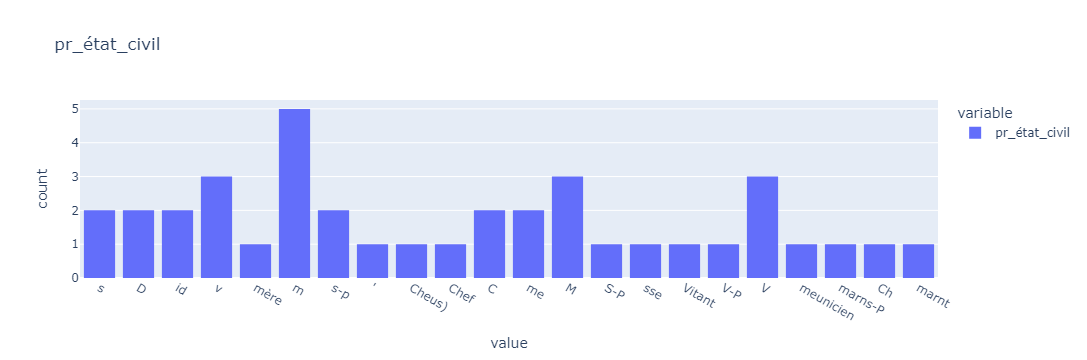

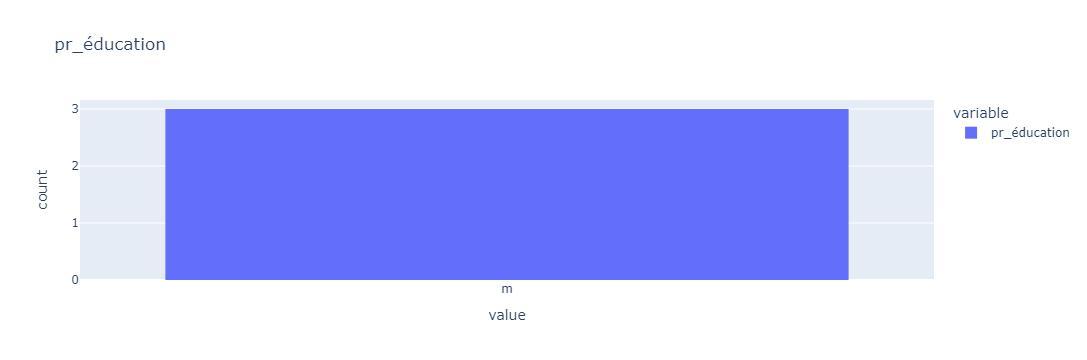

In [22]:
px.line(first_name_df, x= "firstname", y="male").show()
px.line(first_name_df, x= "firstname", y="female").show()
for col in expanded_df:
    px.histogram(expanded_df[col], title = col).show()

### Sélection de variables

Après étude on décide de conserver les variables suivantes:

In [83]:
df_select_gr = pd.DataFrame(
    { 
        "sex": expanded_df["sex"],
        "nom": expanded_df["gr_firstname"],
        "metier": expanded_df["gr_occupation"],
        "lien_famille": expanded_df["gr_link"],
        "civilite": expanded_df["gr_civil_status"],
    }
)

df_select_pr = pd.DataFrame(
    { 
        "sex": expanded_df["sex"],
        "nom": expanded_df["pr_prénom"],
        "metier": expanded_df["pr_profession"],
        "lien_famille": expanded_df["pr_relation"],
        "civilite": expanded_df["pr_état_civil"],
    }
)

### Variable synthétique

On agrège ensuite l'information de la deuxièmes bases en une colonne appelée \textbf{feminite\_nom} qui fait la différence des logarithmes du nombre de femmes et du nombre d'hommes portant le même nom que l'individu. Lorsque le nom n'est pas dans la liste statistique on choisit le nom le plus proche selon la distance d'édition.

not exact comparaison replace anroine by antoine
not exact comparaison replace branislav by stanislas
not exact comparaison replace angène by angèle
not exact comparaison replace herandre by leandre
not exact comparaison replace oarguerite by marguerite
not exact comparaison replace vigmie by mimie
not exact comparaison replace angloise by aloise
not exact comparaison replace feris by denis
not exact comparaison replace jregues by jacques
not exact comparaison replace vaude by haude
not exact comparaison replace gilbeuse by gilberte
not exact comparaison replace branistau by stanislas
not exact comparaison replace mamiolas by mariola
not exact comparaison replace gadeleine by madeleine
not exact comparaison replace ctiennette by etiennette
not exact comparaison replace aupène by eugène
not exact comparaison replace clause by claude
not exact comparaison replace gilbeup by gilbert
not exact comparaison replace marthy by marthe
not exact comparaison replace faul by paul
not exact compara

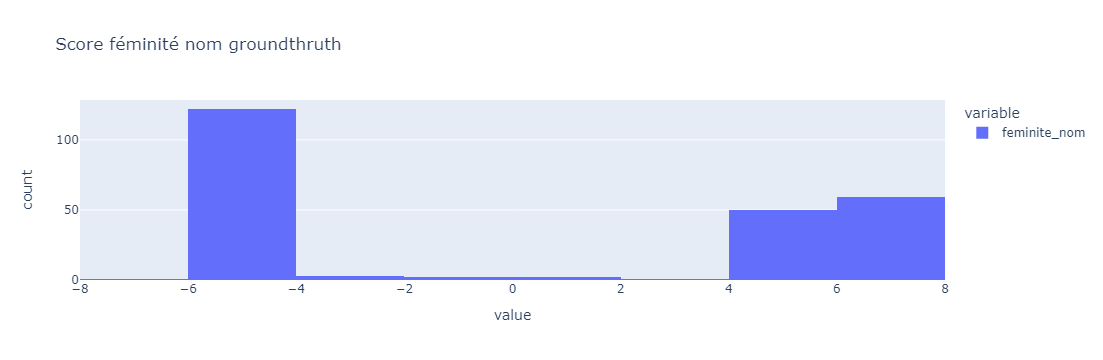

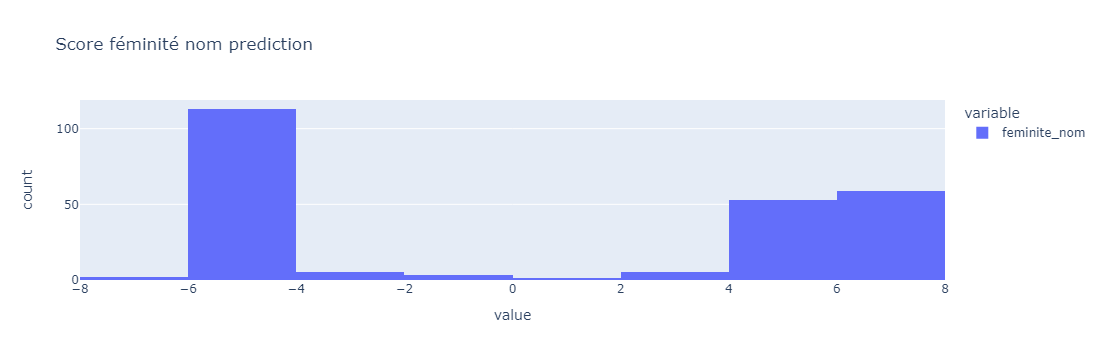

In [84]:
###########
#  utils  #
###########

def add_feminite_nom(df):
    for i, row in df.iterrows():
        name = row["nom"]
        if not pd.isnull(name):
            name_lower = name.lower()
            lst_name = name_lower.split("-")
            lst_score = []
            for name_bloc in lst_name:
                mask = first_name_df['firstname']==name_bloc
                # print(name_bloc, mask.sum())
                if mask.sum()>0:
                    n_femme = first_name_df.loc[mask, 'female'].iloc[0]
                    n_homme = first_name_df.loc[mask, 'male'].iloc[0]
                else:
                    dist = first_name_df['firstname'].astype("str").apply(lambda st: nltk.edit_distance(st, name_bloc))    
                    idx = np.argmin(dist)
                    print(f"not exact comparaison replace {name_bloc} by {first_name_df.loc[idx, 'firstname']}")
                    n_femme = first_name_df.loc[idx, 'female']
                    n_homme = first_name_df.loc[idx, 'male']
                score = 0
                if n_femme>0:
                    score += np.log(n_femme)
                if n_homme>0:
                    score -= np.log(n_homme)
                lst_score.append(score)
                
            df.loc[i, "feminite_nom"] = np.round(np.mean(lst_score),3)  

############
#  script  #
############

add_feminite_nom(df_select_gr)
add_feminite_nom(df_select_pr)

px.histogram(df_select_gr["feminite_nom"], title = "Score féminité nom groundthruth").show()
px.histogram(df_select_pr["feminite_nom"], title = "Score féminité nom prediction").show()

### Amélioration des données textuelles

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\146199853.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


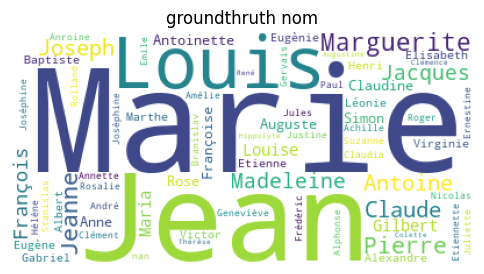

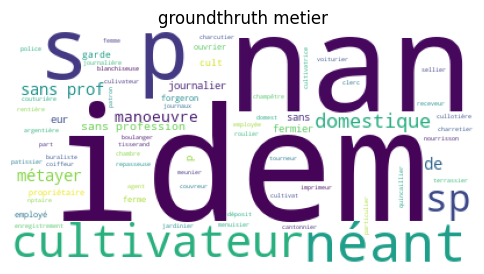

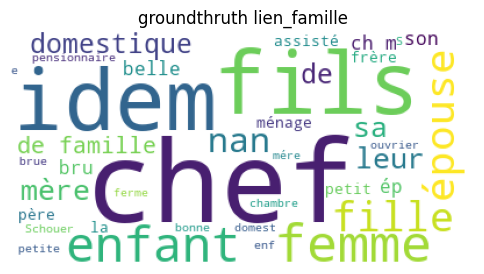

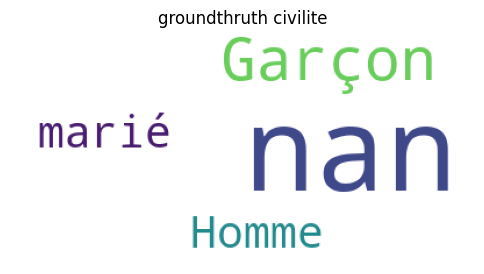

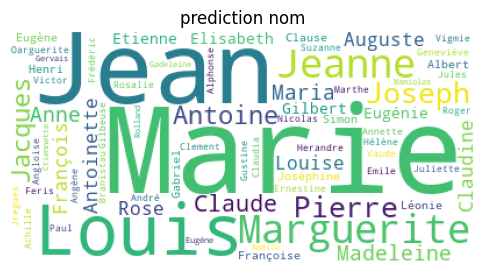

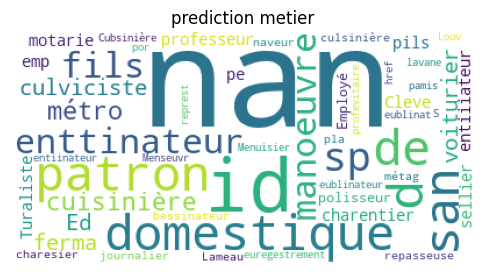

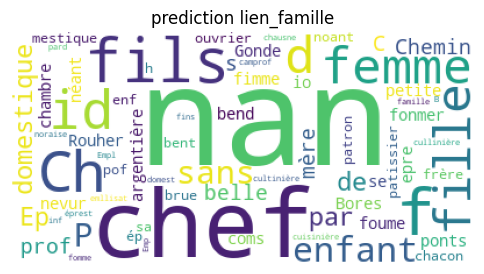

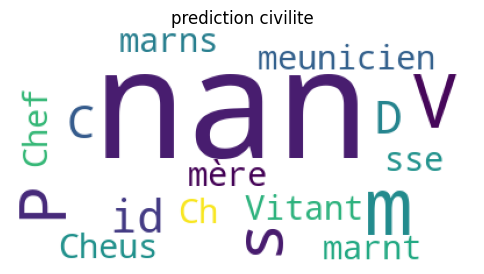

In [85]:
###########
#  utils  #
###########

def my_wordcloud(series: pd.Series, size: int = 10, title: str = "") -> plt.Figure:
    """
    Crée et retourne une visualisation de type nuage de mots à partir d'une
    série donnée.

    Args:
        series (pd.Series): La série à partir de laquelle
            créer le nuage de mots.
        size (int, optional): La taille de la figure générée (en pouces).
            Défaut à 10.
        title (str, optional): Le titre de la figure générée. Défaut à "".

    Returns:
        plt.figure: La figure du nuage de mots généré.
    """
    fig = plt.figure()
    text = " ".join(series.astype(str))
    wordcloud = WordCloud(background_color="white", max_words=70).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    return fig

############
#  script  #
############

for name,dataset in [("groundthruth",df_select_gr), ("prediction",df_select_pr)]:
    for txt_feat in ["nom", "metier", "lien_famille", "civilite"]:
        my_wordcloud(dataset[txt_feat], size = 6, title = f"{name} {txt_feat}").show()

In [79]:
df_select_pr.columns

Index(['sex', 'nom', 'metier', 'lien_famille', 'civilite', 'feminite_nom'], dtype='object')

In [91]:
###########
#  utils  #
###########

def _standardize_string(
        st: str, stopwords, dct_replace, stemmer: callable = lambda lst: lst
    ) -> str:

        # lower
        st = st.lower()
    
        # no accents
        st = unicodedata.normalize("NFD", st)
        st = st.encode("ascii", "ignore")
        st = str(st.decode("utf-8")).replace(".", "").replace("'", "").replace("  ", " ").replace("-", " ")

        # replace
        for word,lst in dct_replace.items():
            if st in lst:
                st = word            
        
        # decomposition for word transformations
        lst = st.split()
        # no stopwords and stemmerization
        st = " ".join([stemmer(w) for w in lst if w not in stopwords])
        if st in stopwords:
            st = ""

        return st


def _standardize_txt_feat(df, txt_ft, stopwords, dct_replace, stemmer):
        f_aux = lambda st: _standardize_string(st, stopwords=stopwords, dct_replace=dct_replace, stemmer=stemmer)
        df[txt_ft] = df[txt_ft].apply(f_aux)
        return df

def preprocess_txt_features(
    df0, 
    lst_txt_ft, 
    stopwords,
    dct_replace,
    stemmer: callable = lambda lst: lst,
):
    df = df0.copy()
    for txt_ft in lst_txt_ft:
        df[txt_ft] = df[txt_ft].astype("str").fillna("")
        df = _standardize_txt_feat(df, txt_ft, stopwords, dct_replace, stemmer)
    return df

############
#  script  #
############

stopwords= tuple(["idem", "id", 
                  "nan", "neant", 
                  "son", "sa", "le", "la", "leur", "de",
                  "enf", "enfant","menage", "famille",
                  "s", "e", "d", "f", "c", "p", "b", "v", "m", "p"])

dct_replace = {
    "sans profession":["sans prof", 'sp', "sans p", "s p", "sans", "s pr", 'sans-mof', "san"],
    "cultivateur":["cult"],
    "employer":["em"],
    "epouse":['ep', "ep e"],
    "chef":["ch", 'ch m', 'chef de menage']
}

print("Stop words: \n",stopwords)


lst_txt_ft = ['nom', 'metier', 'lien_famille', 'civilite']

df_select_gr_proc = preprocess_txt_features(
    df_select_gr, 
    lst_txt_ft, 
    stopwords,
    dct_replace,
    stemmer = lambda lst: lst,
)

df_select_pr_proc = preprocess_txt_features(
    df_select_pr, 
    lst_txt_ft, 
    stopwords,
    dct_replace,
    stemmer = lambda lst: lst,
)

Stop words: 
 ('idem', 'id', 'nan', 'neant', 'son', 'sa', 'le', 'la', 'leur', 'de', 'enf', 'enfant', 'menage', 'famille', 's', 'e', 'd', 'f', 'c', 'p', 'b', 'v', 'm', 'p')


C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\samud\AppData\Local\Temp\ipykernel_21336\606144222.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Use

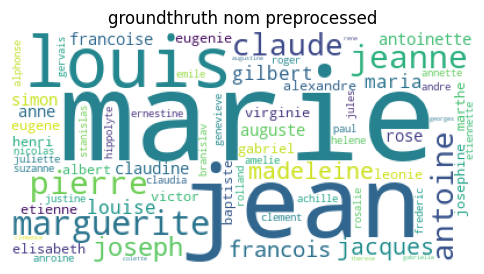

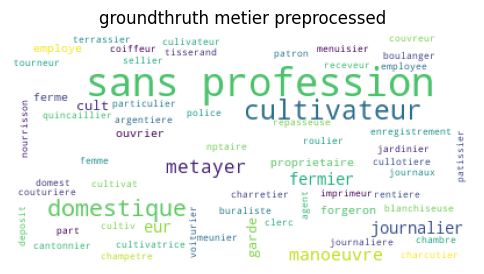

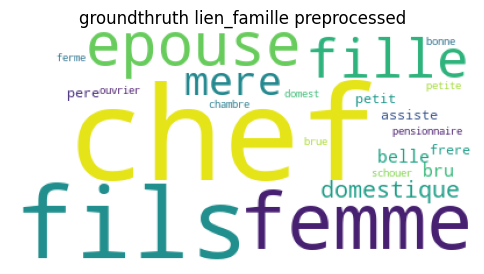

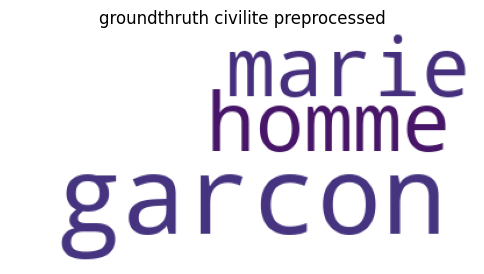

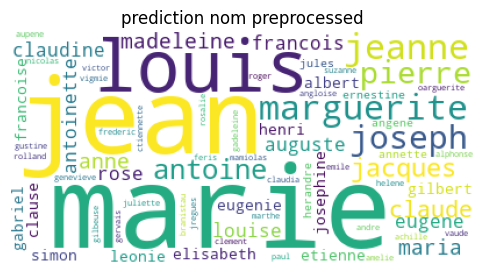

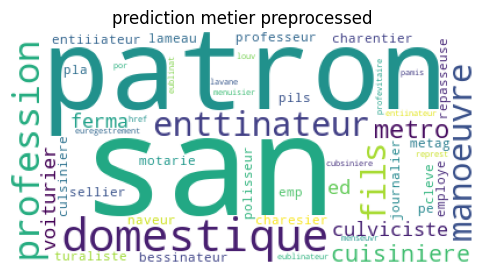

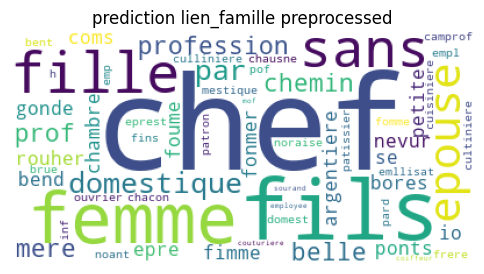

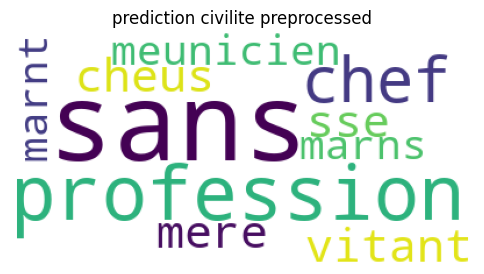

In [92]:
for name, dataset in [("groundthruth",df_select_gr_proc), ("prediction",df_select_pr_proc)]:
    for txt_feat in ["nom", "metier", "lien_famille", "civilite"]:
        my_wordcloud(dataset[txt_feat], size = 6, title = f"{name} {txt_feat} preprocessed").show()

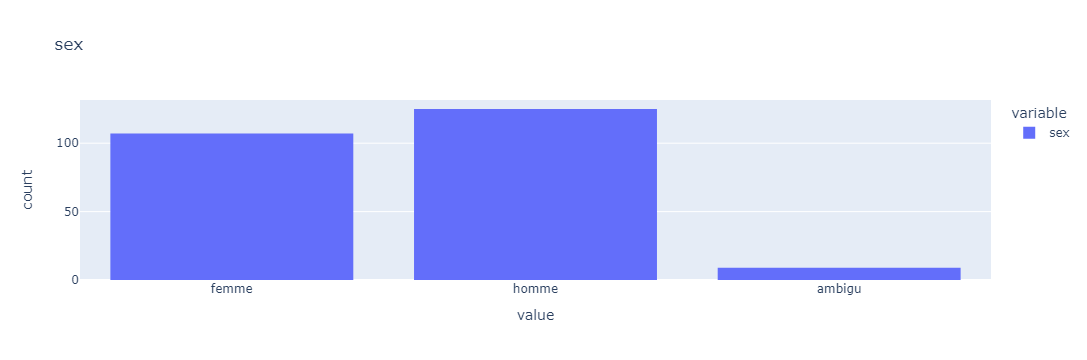

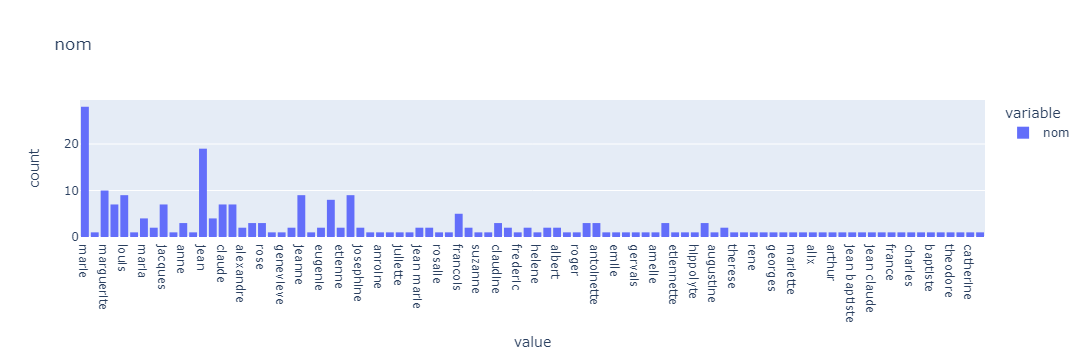

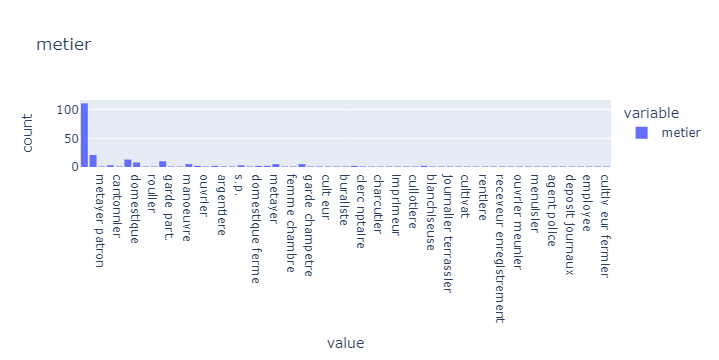

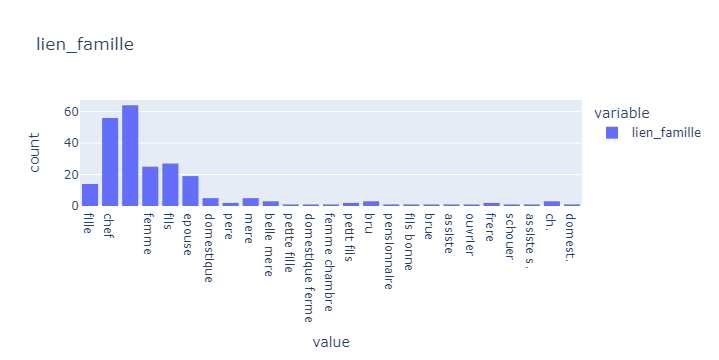

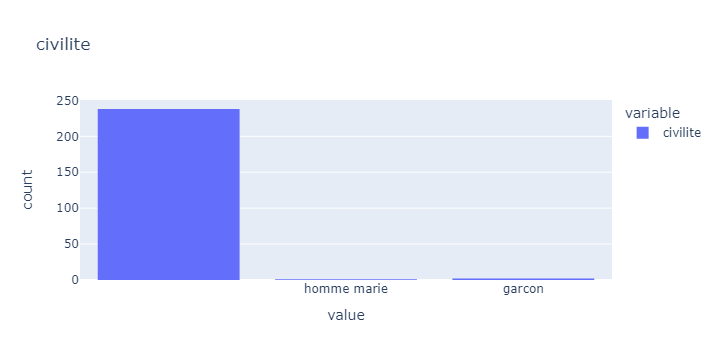

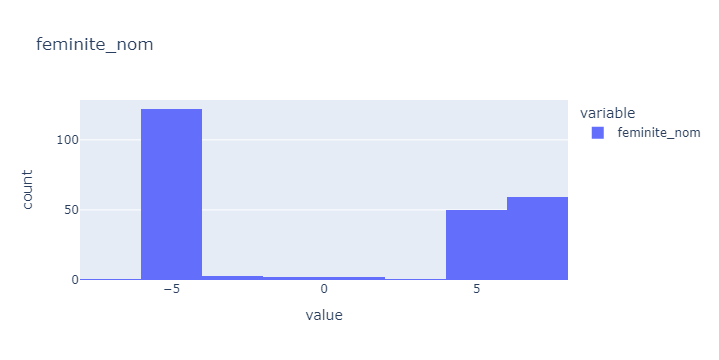

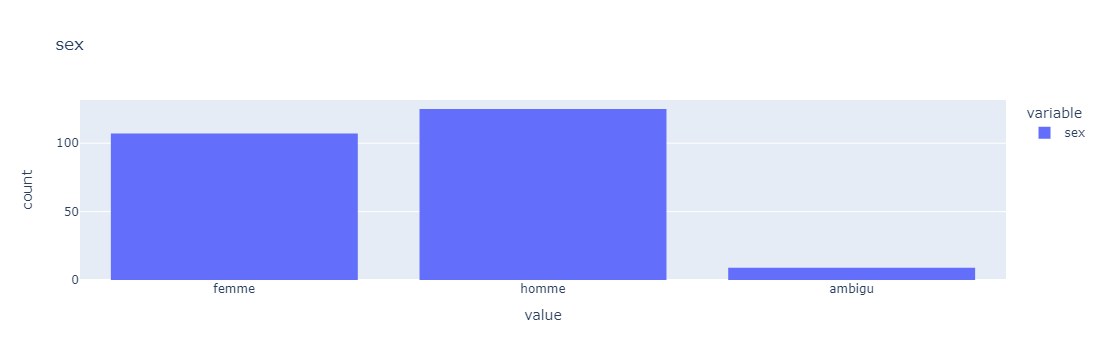

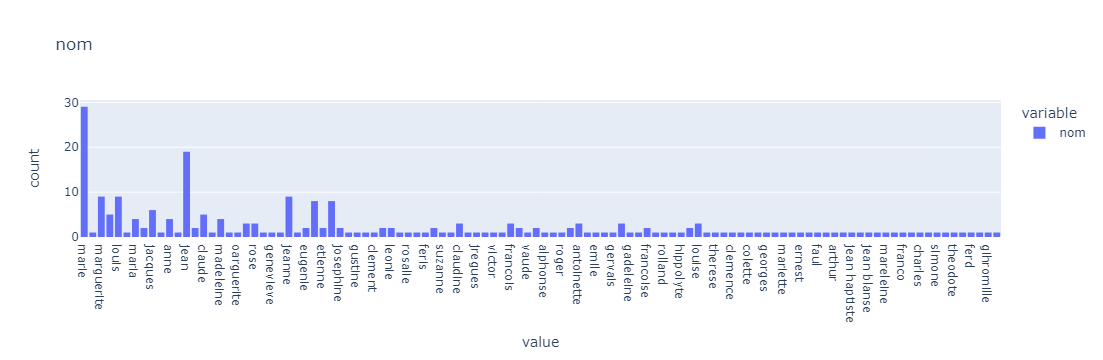

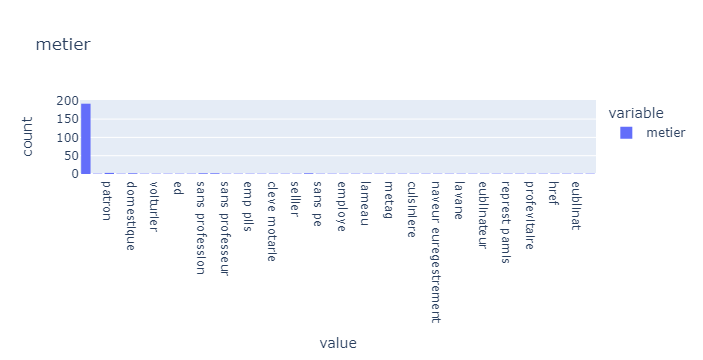

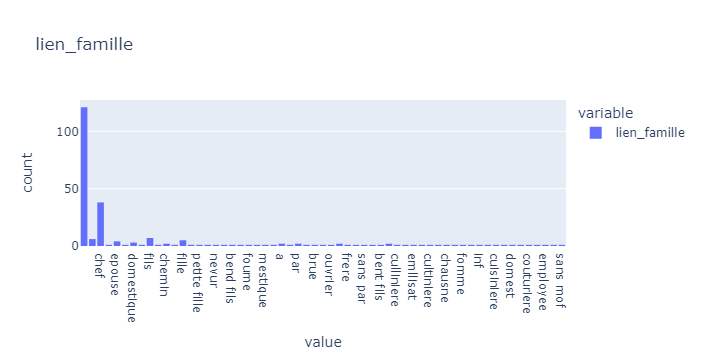

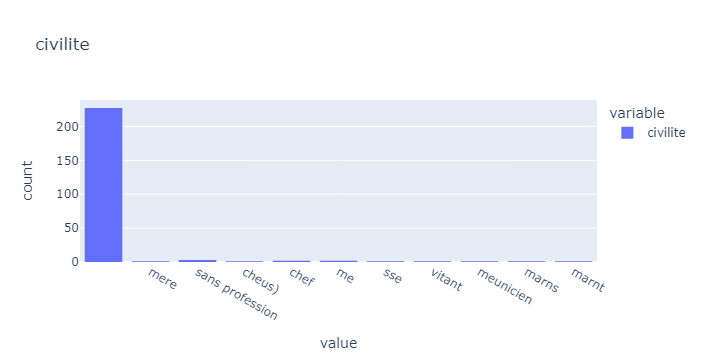

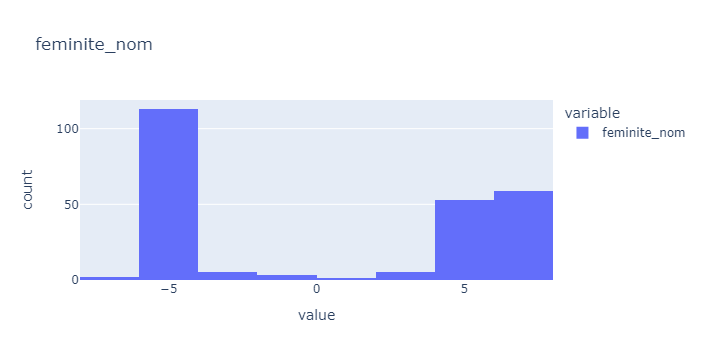

In [90]:
for col in df_select_gr_proc:
    px.histogram(df_select_gr_proc[col], title = col).show()
for col in df_select_pr_proc:
    px.histogram(df_select_pr_proc[col], title = col).show()

### Split and saving

In [98]:
gr_raw = pd.DataFrame({"sex":transcript_df["sex"]})
gr_raw["text"]=transcript_df["groundtruth"]
gr_raw["feminite_nom"]=df_select_gr_proc["feminite_nom"]

pr_raw = pd.DataFrame({"sex":transcript_df["sex"]})
pr_raw["text"]=transcript_df["prediction"]
pr_raw["feminite_nom"]=df_select_pr_proc["feminite_nom"]

In [99]:
seed = 42


gr_raw_train, gr_raw_test = train_test_split(
            gr_raw,
            test_size=0.6,
            random_state=seed,
            shuffle=True,
)

pr_raw_train, pr_raw_test = train_test_split(
            pr_raw,
            test_size=0.6,
            random_state=seed,
            shuffle=True,
)


gr_proc_train, gr_proc_test = train_test_split(
            df_select_gr_proc,
            test_size=0.6,
            random_state=seed,
            shuffle=True,
)

pr_proc_train, pr_proc_test = train_test_split(
            df_select_pr_proc,
            test_size=0.6,
            random_state=seed,
            shuffle=True,
)

data_dict = {
    "gr_raw_train":gr_raw_train,
    "gr_raw_test":gr_raw_test,
    "pr_raw_train":pr_raw_train,
    "pr_raw_test":pr_raw_test,
    "gr_proc_train":gr_proc_train,
    "gr_proc_test":gr_proc_test,
    "pr_proc_train":pr_proc_train,
    "pr_proc_test":pr_proc_test,
}

with open(data_path.joinpath("data_dict.pkl"), 'wb') as file:
    pickle.dump(data_dict, file)